In [ ]:
!pip install memory_profiler

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time

from typing import Callable

In [3]:
class SampleSet:
  def __init__(self, Xs: np.ndarray, ys: np.ndarray):
    assert Xs.shape[0] == ys.shape[0]
    self.Xs = Xs
    self.ys = ys
    self.dim = Xs.shape[1] - 1
    self.sample_size = Xs.shape[0]


class SteppingFunction:
  def __init__(self, pt_grad = lambda w, pt_x, pt_y: -2 * (pt_y - w.dot(pt_x)) * pt_x):
    self.pt_grad = pt_grad

  def calc_pt_grad(self, w, pt_x, pt_y):
    return self.pt_grad(w, pt_x, pt_y)

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    return prev_x

  def __call__(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int) -> float:
    return self.fun(prev_x, grad, step_number)


class StepBasedSF(SteppingFunction):
  def __init__(self, a: float, d: float, r: int):
    super().__init__()
    self.a = a
    self.d = d
    self.r = r

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    lr: float = self.a * (self.d ** ((1 + step_number) // self.r))
    return prev_x - lr * grad


class ConvergenceStat:
  def __init__(self, total_epochs: int, total_steps: int, total_points: int):
    self.total_epochs = total_epochs
    self.total_steps = total_steps
    self.total_points = total_points

# Gradient Descent implementation


In [4]:
def sgd_linear_regression(
        sample_set: SampleSet,
        max_epoch: int,
        eps: float,
        batches: int,
        step_fun: SteppingFunction,
        w: np.ndarray = None,
        verbose=False,
        normalize=False
) -> (np.ndarray, ConvergenceStat):
  # y[i] = w[i] * x[i]
  # w' = w - lr * dL / dw
  # L(w) = 1 / l * sum for i in range(1, l) sqr(y[i] - <w, X[i]>)
  # dL / dw = - 1 / l * sum for i in range(1, l) 2 * (y[i] - <w, X[i]>) * X[i]
  sample_size: int = sample_set.sample_size
  dimension: int = sample_set.dim
  if not isinstance(w, np.ndarray):
    w = np.random.random(dimension + 1)
  ws = [w]

  # Statistics
  total_epochs = 0
  total_steps = 0
  total_points = 0

  # Using moving average of MSE as halt criteria
  moving_average_min = 10
  moving_average_deque = collections.deque()
  moving_average_sum = 0
  Xs = sample_set.Xs.copy()

  if normalize:
    Xs_min = Xs[:, 1:].min(axis=0)
    Xs_max = Xs[:, 1:].max(axis=0)
    Xs[:, 1:] = (Xs[:, 1:] - Xs_min) / (Xs_max - Xs_min)


  for epoch in range(max_epoch):
    perm = np.random.permutation(sample_size)
    X_perm, y_perm = Xs[perm], sample_set.ys[perm]
    batch_size = int(sample_size / batches)
    overall_error = 0
    for batch in range(batches):
      sup_pt_num = batch_size * (batch + 1) if batch < batches - 1 else sample_size
      error = np.zeros(w.shape)
      cnt = 0
      for pt_num in range(batch * batch_size, sup_pt_num):
        pt_x, pt_y = X_perm[pt_num], y_perm[pt_num]
        delta = pt_y - w.dot(pt_x)
        error += step_fun.calc_pt_grad(w, pt_x, pt_y)
        cnt += 1
        overall_error += delta ** 2
        total_points += 1
      error /= cnt
      w = step_fun(w, error, len(ws))
      ws.append(w)
      total_steps += 1

    total_epochs += 1

    # Halt criteria
    overall_error /= sample_size

    if epoch > moving_average_min:
      mov_error = moving_average_sum / len(moving_average_deque)
      if abs(overall_error - mov_error) < eps:
        if verbose:
          print("Stopped due to halt criteria")
        break

    moving_average_deque.append(overall_error)
    moving_average_sum += overall_error
    if len(moving_average_deque) > moving_average_min:
      tail = moving_average_deque.popleft()
      moving_average_sum -= tail

  return np.array(ws), ConvergenceStat(total_epochs, total_steps, total_points)


In [5]:
np.array([[1, 2], [2, 4], [4, 5], [6, 7]]).shape

(4, 2)

# Generate samples

In [6]:
import enum


class NoiseLevel:
  class NoiseKind(enum.Enum):
    NEIGHBOURHOOD = 1
    UNIFORM = 2

  def __init__(self, kind: NoiseKind, min_lvl: float, max_lvl: float):
    assert (kind == NoiseLevel.NoiseKind.UNIFORM and min_lvl == max_lvl
            or kind == NoiseLevel.NoiseKind.NEIGHBOURHOOD and min_lvl <= max_lvl)
    self.min_lvl = min_lvl
    self.max_lvl = max_lvl
    self.kind = kind

Here we can see method that generates sample set along with task itself (parameter w to be found)

There are two modes in which we can generate samples: NEIGHBOURHOOD and UNIFORM

UNIFORM mode just adds uniformly distributed random variable to purely evaluated point

NEIGHBOURHOOD takes point from current point's neighbourhood and evaluates it purely

In [7]:
def generate_samples(n: int, x_dim: int, noise_level: NoiseLevel, const_bound: float, bounds: np.ndarray) -> (SampleSet, np.ndarray):
  assert x_dim > 0
  assert bounds.shape == (x_dim, )
  fun: Callable[[np.ndarray], float]

  if noise_level.kind == NoiseLevel.NoiseKind.NEIGHBOURHOOD:
    # Configure noise levels along each axis
    if x_dim == 1 and noise_level.max_lvl != noise_level.min_lvl:
      print("Warning: noise_level.min_lvl may not be present in noise_levels")
    noise_levels = np.random.random(x_dim + 1) * (noise_level.max_lvl - noise_level.min_lvl) + noise_level.min_lvl

    # Ensure that maximum and minimum noise levels are feasible
    noise_levels[1] = noise_level.min_lvl
    noise_levels[-1] = noise_level.max_lvl

    fun = lambda x: w.dot(x * (1 + noise_levels * np.random.random(1) * const_bound))
  elif noise_level.kind == NoiseLevel.NoiseKind.UNIFORM:
    noise = noise_level.min_lvl
    fun = lambda x: w.dot(x) + noise * (np.random.random(1) - 0.5) * const_bound
  else:
    assert False, "Unreachable statement"

  # Randomly generate w vector of numbers [0, 1],
  # yet free constant should be in [-l1_bound / 2; l1_bound / 2]
  w: np.ndarray = np.random.random(x_dim + 1)
  w[0] = np.random.random(1) * const_bound / 2

  Xs: [np.ndarray] = []
  ys: [float] = []

  for i in range(n):
    # Ensure that free constant is indeed independent of sample
    x: np.ndarray = np.random.random(x_dim) * bounds
    x = np.insert(x, 0, -1)

    y = fun(x)

    Xs.append(x)
    ys.append(y)

  return SampleSet(np.array(Xs), np.array(ys)), w

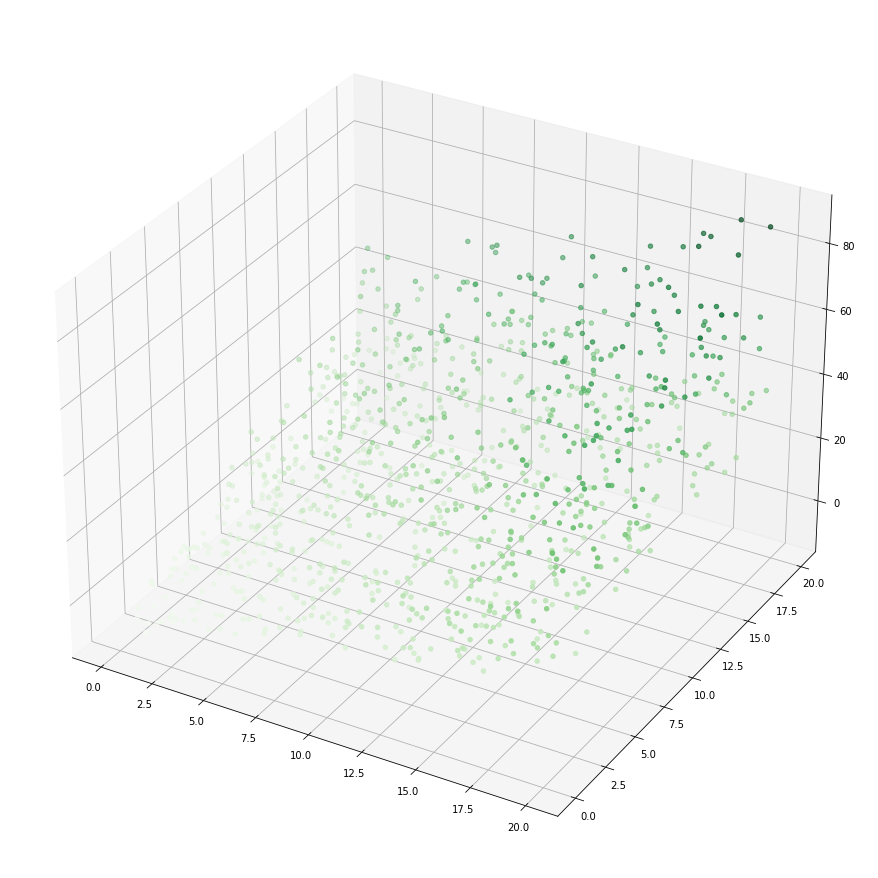

In [8]:
def draw_example_neighbourhood():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.NEIGHBOURHOOD, 0.1, 0.2), 20, np.array([20, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_neighbourhood()

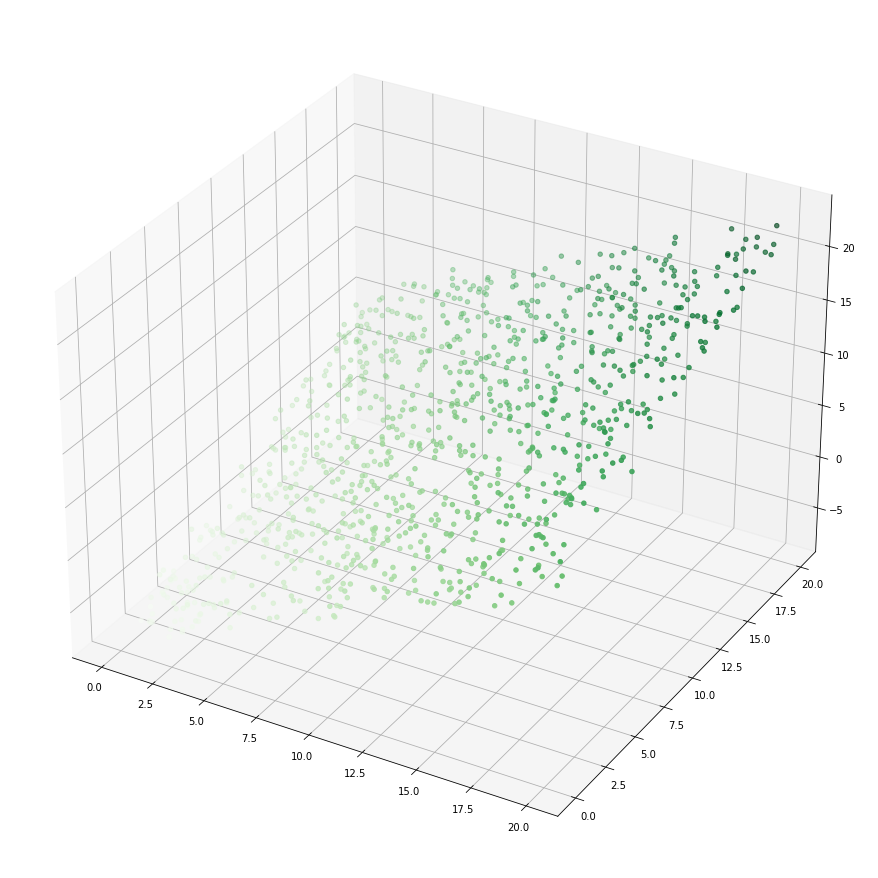

In [9]:
def draw_example_uniform():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.1, 0.1), 20, np.array([20, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_uniform()

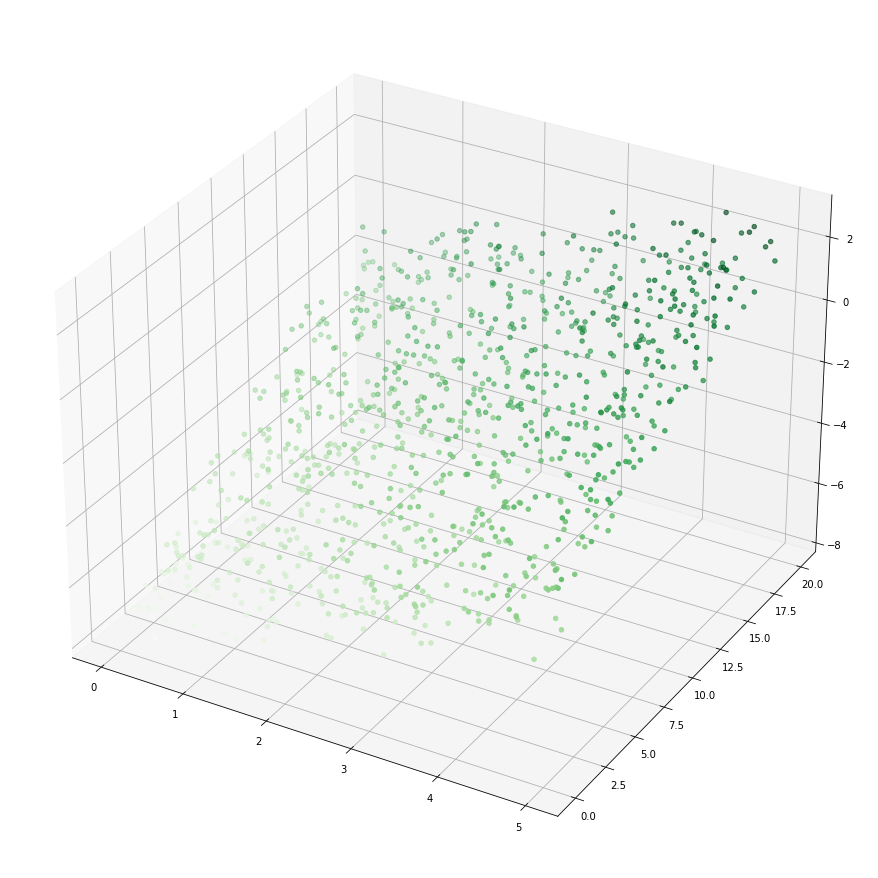

In [10]:
def draw_example_uniform_denormalized():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.1, 0.1), 20, np.array([5, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_uniform_denormalized()

# Test of SGD

Here we can see special case with dimension 2 and how naive SGD handles it

Sometimes it really does work correctly, but sometimes guessed surface is far from
true one.

Green dots are points from sample set, blue surface is the guessed surface by SGD

[4.24630217 0.02920888 0.46830813]
Stopped due to halt criteria
[0.7783179  0.31699364 0.24272855]
sgd_path consists of 373 vectors


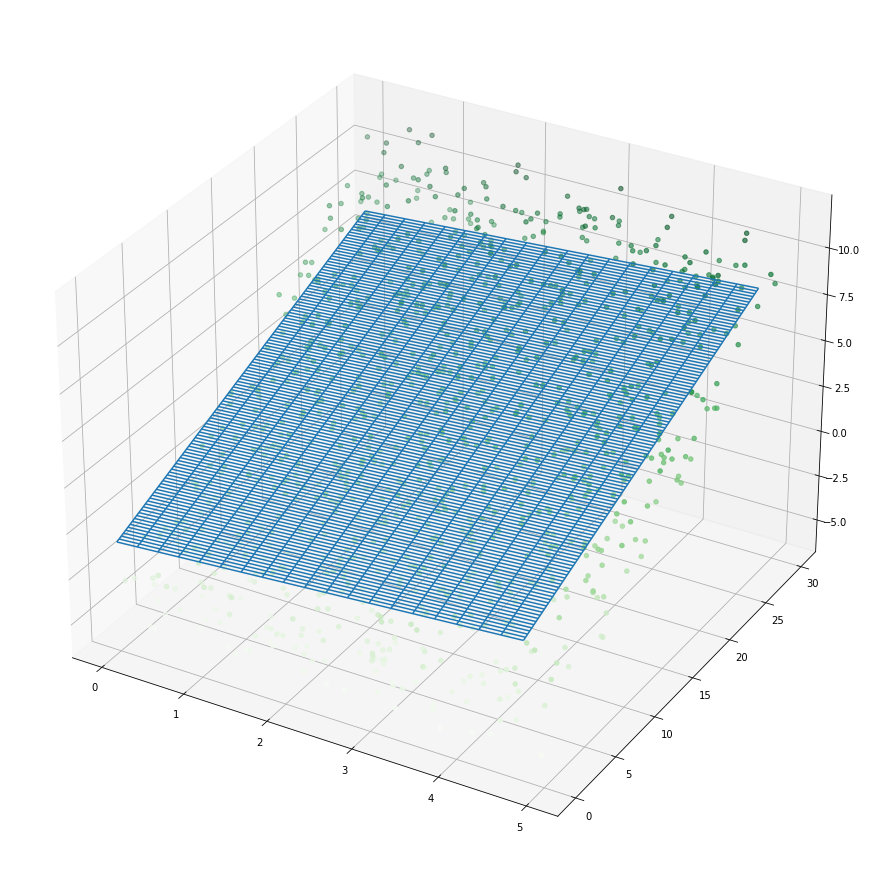

In [11]:
def test_sgd_uniform_noise():
  sample_size = 1000
  x_dim = 2
  const_bound = 20
  x_bound = 5
  y_bound = 30
  bounds = np.array([x_bound, y_bound])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  print(w_true)
  step_fun = StepBasedSF(1, 0.001, 2)

  sgd_path, _ = sgd_linear_regression(sample_set, 40, 0.00001, int(np.sqrt(sample_size)), step_fun, verbose=True)
  print(sgd_path[-1])
  print(f"sgd_path consists of {len(sgd_path)} vectors")
  w_sgd: np.ndarray = sgd_path[-1]
  x_sgd = np.arange(0, x_bound, 0.25)
  y_sgd = np.arange(0, y_bound, 0.25)

  z_sgd = np.array([[np.array([-1, x, y]).dot(w_sgd) for x in x_sgd] for y in y_sgd])
  x_sgd, y_sgd = np.meshgrid(x_sgd, y_sgd)
  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')
  ax.plot_wireframe(x_sgd, y_sgd, z_sgd, rstride=1, cstride=1)

test_sgd_uniform_noise()

  # Convergence investigation

Here is dependency of three convergence characteristics: number of epochs, number of steps
and number of points evaluated, on batch count. As we can see, there are several local minima
for points evaluated.

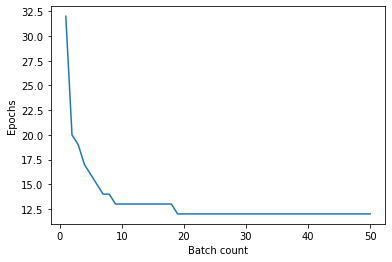

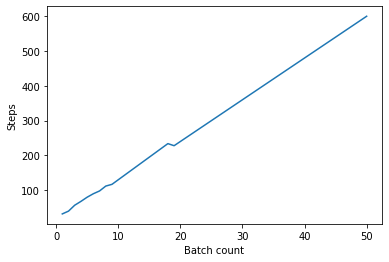

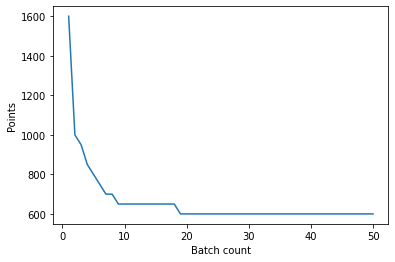

In [12]:
def convergence_investigation():
  sample_size = 50
  x_dim = 10
  const_bound = 20
  bounds = np.array([5 * i for i in range(1, 11)])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)

  step_fun = StepBasedSF(0.001, 0.001, 5)
  epochs = []
  steps = []
  points = []
  batches = []

  for batch_count in range(1, sample_size + 1):
    sgd_path, stat = sgd_linear_regression(sample_set, 40, 0.000001, batch_count, step_fun)

    epochs.append(stat.total_epochs)
    steps.append(stat.total_steps)
    points.append(stat.total_points)
    batches.append(batch_count)

  plt.plot(batches, epochs)
  plt.xlabel('Batch count')
  plt.ylabel('Epochs')
  plt.show()

  plt.plot(batches, steps)
  plt.xlabel('Batch count')
  plt.ylabel('Steps')
  plt.show()

  plt.plot(batches, points)
  plt.xlabel('Batch count')
  plt.ylabel('Points')
  plt.show()


convergence_investigation()

# Normalized sample set convergence investigation

For normalized sample set picture is the same, except almost everywhere number
of epochs is less than for non-normalized sample set, so convergence is better.

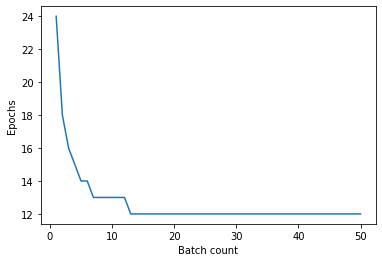

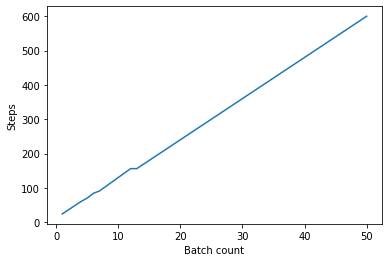

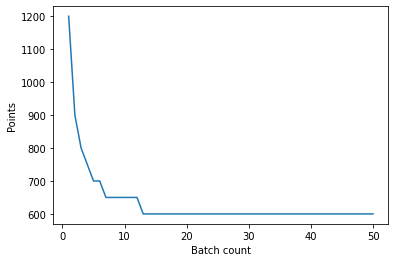

In [13]:
def convergence_investigation_normalized():
  sample_size = 50
  x_dim = 10
  const_bound = 20
  bounds = np.array([5 * i for i in range(1, 11)])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)

  step_fun = StepBasedSF(0.001, 0.001, 5)
  epochs = []
  steps = []
  points = []
  batches = []

  for batch_count in range(1, sample_size + 1):
    sgd_path, stat = sgd_linear_regression(sample_set, 40, 0.0000001, batch_count, step_fun, normalize=True)
    
    epochs.append(stat.total_epochs)
    steps.append(stat.total_steps)
    points.append(stat.total_points)
    batches.append(batch_count)

  plt.plot(batches, epochs)
  plt.xlabel('Batch count')
  plt.ylabel('Epochs')
  plt.show()

  plt.plot(batches, steps)
  plt.xlabel('Batch count')
  plt.ylabel('Steps')
  plt.show()

  plt.plot(batches, points)
  plt.xlabel('Batch count')
  plt.ylabel('Points')
  plt.show()


convergence_investigation_normalized()

# Modifications

Implementations of Nesterov, Momentum, AdaGrad, RMSProp and Adam optimizations.


In [26]:
class NesterovSF(SteppingFunction):
  def __init__(self, a: float, b: float):
    super().__init__()
    self.b = b
    self.a = a
    self.prev_g = 0

  def calc_pt_grad(self, w, pt_x, pt_y):
    return self.pt_grad(w - self.b * self.prev_g, pt_x, pt_y)

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    self.prev_g = self.b * self.prev_g + self.a * grad
    return prev_x - self.prev_g


class MomentumSF(SteppingFunction):
  def __init__(self, a: float, b: float):
    super().__init__()
    self.b = b
    self.a = a
    self.prev_g = 0

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    self.prev_g = self.b * self.prev_g + self.a * grad
    return prev_x - self.prev_g


class AdamGradSF(SteppingFunction):
  def __init__(self, a: float):
    super().__init__()
    self.a = a
    self.v = 0

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    self.v += grad ** 2
    return prev_x - self.a * grad / np.sqrt(self.v)


class RMSPropSF(SteppingFunction):
  def __init__(self, a: float, gamma: float):
    super().__init__()
    self.a = a
    self.gamma = gamma
    self.v = 0

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    self.v = self.gamma * self.v + (1 - self.gamma) * grad ** 2
    return prev_x - self.a * grad / np.sqrt(self.v)


class AdamSF(SteppingFunction):
  def __init__(self, a: float, b1: float = 0.8, b2: float = 0.999, eps: float = 1e-8):
    super().__init__()
    self.a = a
    self.b1 = b1
    self.b2 = b2
    self.eps = eps
    self.m = 0
    self.v = 0

  def fun(self, prev_x: np.ndarray, grad: np.ndarray, step_number: int):
    self.m = self.b1 * self.m + (1 - self.b1) * grad
    self.v = self.b2 * self.v + (1 - self.b2) * grad ** 2
    mt = self.m / (1 - self.b1 ** step_number)
    vt = self.v / (1 - self.b2 ** step_number)
    return prev_x - self.a * mt / (np.sqrt(vt) + self.eps)

# Modifications analysis

Adam is the best

Not optimized SGD is the worst

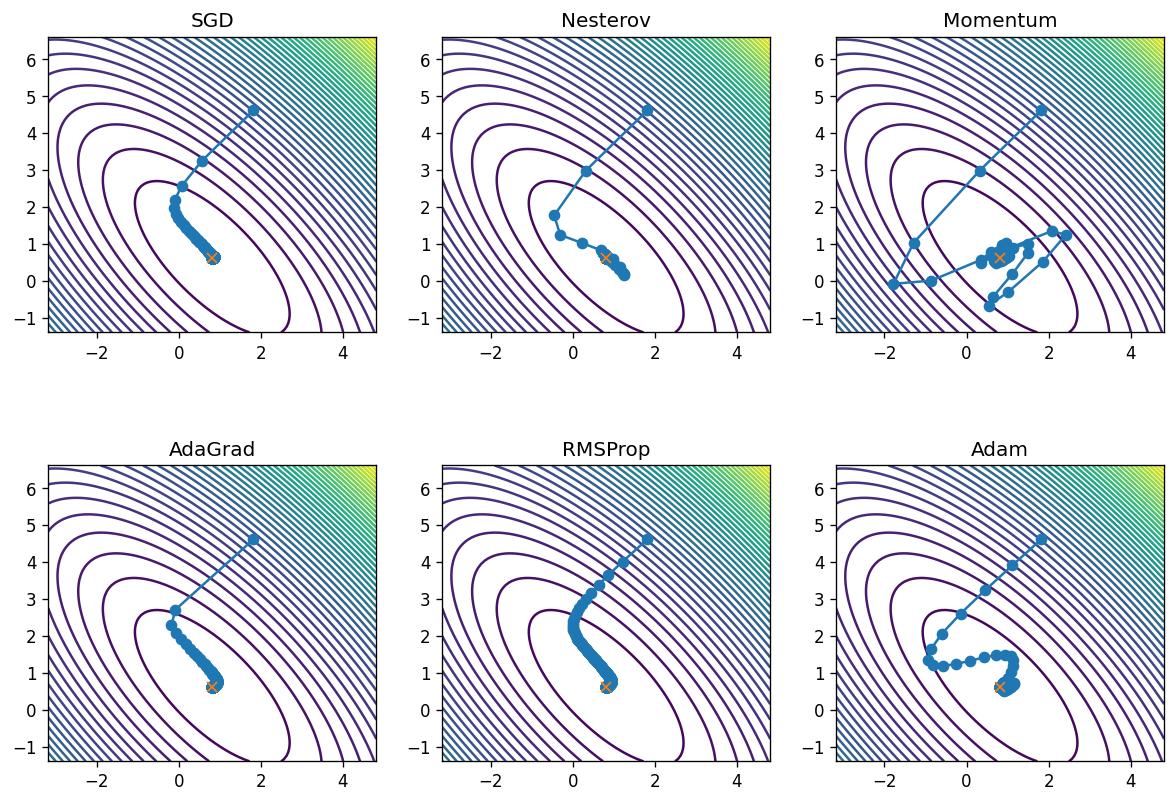

final loss of SGD      is 0.00023326
final loss of Nesterov is 0.00000600
final loss of Momentum is 0.00000845
final loss of AdaGrad  is 0.00000684
final loss of RMSProp  is 0.00000184
final loss of Adam     is 0.00000090


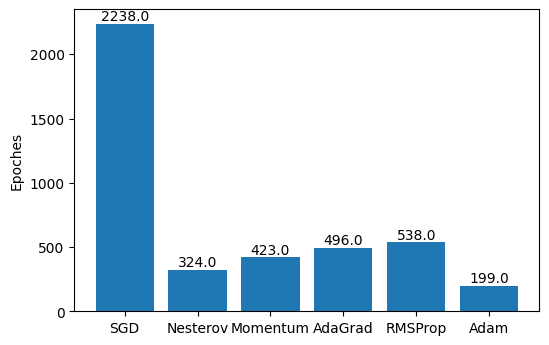

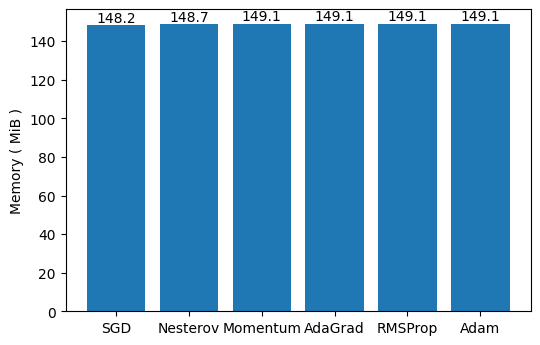

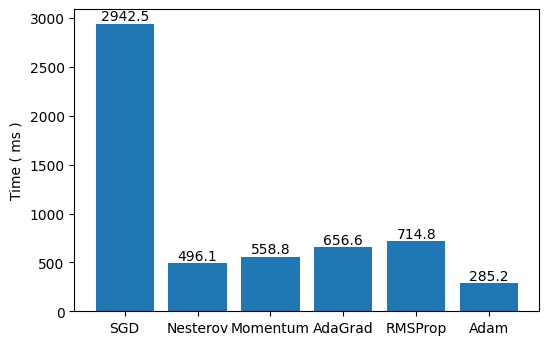

In [28]:
def modifications_analysis():
  sample_size = 100
  x_dim = 2
  const_bound = 0
  bounds = np.array([10, 10])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2),
                                        const_bound, bounds)

  num = 100
  X, Y = np.meshgrid(
    np.linspace(w_true[1] - 4, w_true[1] + 4, num),
    np.linspace(w_true[2] - 2, w_true[2] + 6, num)
  )
  A = np.array([np.repeat(w_true[0], num ** 2), X.flatten(), Y.flatten()])
  B = w_true.reshape(-1, 1)
  f = lambda ws: ((sample_set.Xs @ ws - sample_set.Xs @ B) ** 2).mean(axis=0)
  Z = f(A).reshape(num, num)

  # modifications
  step_fun = StepBasedSF(0.005, 0.5, 1000)
  nesterov_fun = NesterovSF(0.006, 0.85)
  momentum_fun = MomentumSF(0.006, 0.8)
  adam_grad_fun = AdamGradSF(1.9)
  rms_prop_fun = RMSPropSF(0.06, 0.99)
  adam_fun = AdamSF(0.7)

  names = ['SGD', 'Nesterov', 'Momentum', 'AdaGrad', 'RMSProp', 'Adam']
  funs = [step_fun, nesterov_fun, momentum_fun, adam_grad_fun, rms_prop_fun, adam_fun]
  n = len(funs)

  epoches = np.zeros(n)
  losses = np.zeros(n)
  memory_usages = []
  time_usages = []

  # plot traces
  fig = plt.figure(dpi=120)
  fig.set_figwidth(12)
  fig.set_figheight(8)
  for i in range(n):
    start_t = time.time()
    (mem_stats, (path, stats)) = memory_usage(
      (sgd_linear_regression,
       (sample_set, 1000000, 1e-6, 1, funs[i],),
       {'w': np.array([w_true[0], w_true[1] + 1, w_true[2] + 4])}
       ), timestamps=True, retval=True)
    losses[i] = f(path.T)[-1]
    epoches[i] = stats.total_epochs
    memory_usages.append(np.max(np.array(mem_stats)[:,0]))
    time_usages.append(1e3 * (np.max(np.array(mem_stats)[:,1]) - start_t))
    plt.subplot(231 + i)
    plt.contour(X, Y, Z, levels=45)
    plt.title(names[i])
    plt.plot(path[:, 1], path[:, 2], 'o-')
    plt.plot(w_true[1], w_true[2], 'x')
  plt.subplots_adjust(hspace=0.45)
  plt.show()

  for i in range(n):
    print("final loss of " + names[i].ljust(8) + " is", "%0.8f" % losses[i])

  # plot bars
  def plot_bar(data: np.ndarray, ylabel: str):
    plt.figure(dpi=100)
    plt.ylabel(ylabel)
    rects = plt.bar(names, data)
    for rect in rects:
      height = rect.get_height()
      plt.annotate('{:.1f}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 0),
                  textcoords="offset points",
                  ha='center', va='bottom')
    plt.show()

  plot_bar(epoches, 'Epoches')
  plot_bar(memory_usages, 'Memory ( MiB )')
  plot_bar(time_usages, 'Time ( ms )')


modifications_analysis()